In [38]:
import pandas as pd 
import numpy as np 
import datetime as dt 
import requests
import warnings
import json
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

plt.style.use('ggplot')

<h1 style="color:turquoise">Get Data from API</h1>

In [8]:
"""
Potentially useful data
SME Export Value: https://data.go.th/dataset/export2556-2566
SME Import Value: https://data.go.th/dataset/2556-2566
"""

'\nPotentially useful data\nSME Export Value: https://data.go.th/dataset/export2556-2566\nSME Import Value: https://data.go.th/dataset/2556-2566\n'

In [8]:
def crawl_url_raw(url):
    # Send a GET request to the URL and store the response
    response = requests.get(url)

    # Use BeautifulSoup to parse the HTML content of the response
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all div elements with class "row hoverDownload" or "row hoverDownload active"
    divs = soup.find_all('div', {'class': ['row hoverDownload', 'row hoverDownload active']})
    return divs

def crawl_url(url):
    # Send a GET request to the URL and store the response
    response = requests.get(url)

    # Use BeautifulSoup to parse the HTML content of the response
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all div elements with class "row hoverDownload" or "row hoverDownload active"
    divs = soup.find_all('div', {'class': ['row hoverDownload', 'row hoverDownload active']})

    # Extract the link and title from each div
    results = list()
    # global div
    for div in divs:
        # check if the file is in .xlsx format. if so, get the url
        div = [r for r in div]
        if div[1].find('a').find('img')['alt'] == 'xlsx':
            # name = div[3].find('a')['title'] or div[3].find('a').title
            url = div[1].find('a')['href']
            # print(f'Name = {name} and url = {url}')
            # results[name] = url
            results.append(url)

    # Return the extracted data
    return results


In [9]:
res_list = crawl_url('https://data.go.th/dataset/export2556-2566')

In [4]:
# res_list[:5]

In [5]:
# for each data year, get only first element found (since it's the latest update)
r = r'opendata-export[A-Za-z0-9-.]*'
year_dict = {url: re.findall(r, url)[0][15:19] for url in res_list}

latest_update = dict()
for url, year in year_dict.items():
    if year not in latest_update:
        latest_update[year] = url

latest_update

In [6]:
export_dir = './data/thai_gov_open_data/sme_export'
for year, url in latest_update.items():
    if year in []:
        continue
    print(f'Year = {year} and URL = {url}')
    try:
        # * get file format
        file_format = url.split('.')[-1]
        response = requests.get(url)
        if response.status_code == 200:
            if file_format == 'xlsx':
                df = pd.read_excel(response.content)
                df.to_csv(f'{export_dir}/{str(year)}.csv', index=False)
            elif file_format == 'csv':
                df = pd.read_csv(response.content)
                df.to_csv(f'{export_dir}/{str(year)}.csv', index=False)
            else:
                warnings.warn(f'File format {file_format} not supported', category=UserWarning)
    except:
        print(f'Failed to download from {year}')

<h1 style="color:turquoise">Convert Data from CSV to Parquet</h1>

In [37]:
base_path = './data/thai_gov_open_data/sme_export'
for year in range(2564, 2567):
    path = f'{base_path}/csv/{str(year)}.csv'
    new_path = f'{base_path}/parquet/{str(year)}.parquet'
    df = pd.read_csv(path, skiprows=0)
    df.columns = [c.strip() for c in df.columns]
    df['มูลค่า (บาท)'] = df['มูลค่า (บาท)'].astype(float)
    df['มูลค่า (ดอลล่าร์)'] = df['มูลค่า (ดอลล่าร์)'].astype(float)
    df.to_parquet(new_path, index=False)
    print(f'{str(year)} is completed')

2564 is completed
2565 is completed
2566 is completed


In [29]:
# base_path = './data/thai_gov_open_data/sme_export'
# path = f'{base_path}/2556.csv'
# df = pd.read_csv(path, skiprows=1)
# df.head(2)

<h1 style="color:turquoise">Read Data</h1>

In [13]:
# read data
sme_export_raw = pd.read_parquet('./data/thai_gov_open_data/sme_export/parquet/')
# sme_export_raw = pq.read_table('./data/thai_gov_open_data/sme_export/parquet/')
sme_export_raw.columns = ['country', 'hs2dg', 'hs2dg_desc', 'hs4dg', 'hs4dg_desc', 'value_thb', 'value_usd', 'business_size', 'month', 'year']

sme_export_raw['month'] = sme_export_raw.apply(lambda row: dt.date(row['year'], row['month'], 1), axis = 1)

sme_export_raw.set_index('month', inplace=True)

In [14]:
sme_export_raw.head(3)

,country,hs2dg,hs2dg_desc,hs4dg,hs4dg_desc,value_thb,value_usd,business_size,year
month,,,,,,,,,
2556-06-01,ANDORRA,33,เครื่องหอม เครื่องสำอาง,3307,สิ่งปรุงแต่งที่ใช้ก่อน ระหว่าง หรือหลังการโกนห...,29245.0,990.0,S,2556
2556-11-01,ANDORRA,42,เครื่องหนัง,4202,หีบเดินทางขนาดใหญ่ กระเป๋าใส่เสื้อผ้า กระเป๋าใ...,123.0,4.0,L,2556
2556-11-01,ANDORRA,44,ไม้และของทำด้วยไม้ ถ่านไม้,4420,ไม้ที่ฝังหรือประดับด้วยมุก ด้วยงาช้างหรือวัตถุ...,30.0,1.0,L,2556


In [15]:
# # * total export value by countries and months
country = sme_export_raw[['country', 'value_thb']] \
            .groupby([sme_export_raw.index, 'country']).sum()

# ? divide value_thb by a billion to make it easier to visualize
country['value_thb'] = country['value_thb'].div(1e9)

country['monthly_rank'] = country.groupby([country.index.get_level_values(0)])['value_thb'].rank(method='max', ascending=False).astype(int)

# * top 5 each month
country_top5 = country[country['monthly_rank'] <= 5]
country_top5 = country_top5.sort_values(by=['month', 'monthly_rank'])

In [16]:
country_top5.head(20)

value_thb  monthly_rank
month      country                               
2556-01-01 CHINA          66.680372             1
           JAPAN          55.084690             2
           UNITED STATES  55.047930             3
           HONG KONG      31.629180             4
           MALAYSIA       31.302053             5
2556-02-01 CHINA          66.007389             1
           JAPAN          53.316152             2
           UNITED STATES  53.002822             3
           INDONESIA      29.475045             4
           HONG KONG      28.750672             5
2556-03-01 CHINA          71.035400             1
           JAPAN          58.921514             2
           UNITED STATES  56.302375             3
           HONG KONG      40.242183             4
           MALAYSIA       33.020442             5
2556-04-01 CHINA          59.357664             1
           UNITED STATES  51.619420             2
           JAPAN          50.493094             3
           MALAYSIA       28.696733             4
           INDONESIA      28.010737             5

In [7]:
# sme_export_raw.index

In [3]:
# tmp56 = pd.read_parquet('./data/thai_gov_open_data/sme_export/2556.parquet')
# tmp56.head()

<h3>Top Products Exported</h3>

In [40]:
sme_export_raw.tail(2)

,country,hs2dg,hs2dg_desc,hs4dg,hs4dg_desc,value_thb,value_usd,business_size,year
month,,,,,,,,,
2566-01-01,None,27,เชื้อเพลิงที่ได้จากแร่ น้ำมันแร่ และผลิตภัณฑ์ท...,2710,น้ำมันปิโตรเลียมและน้ำมันที่ได้จากแร่บิทูมินัส...,1.056121e+09,30545804.0,None,2566
2566-02-01,None,27,เชื้อเพลิงที่ได้จากแร่ น้ำมันแร่ และผลิตภัณฑ์ท...,2710,น้ำมันปิโตรเลียมและน้ำมันที่ได้จากแร่บิทูมินัส...,6.668456e+08,20436956.0,None,2566


In [26]:
top_export = sme_export_raw.groupby(['hs2dg']).sum()['value_thb'].reset_index() \
                .sort_values(by='value_thb', ascending=False)

top_export['value_thb_portion'] = top_export['value_thb'].div(top_export['value_thb'].sum()).mul(100)
top_export['cum_portion'] = top_export['value_thb_portion'].cumsum()

# top_export['hs2dg'].nunique() # 208 categories

top_export_pct80 = top_export[top_export['cum_portion'] < 80]
top_export_pct80['hs2dg'].nunique() # 33

/var/folders/cg/6xrmgcbj71nfsp9hqcxq2fzh0000gn/T/ipykernel_2595/2333698224.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_export = sme_export_raw.groupby(['hs2dg']).sum()['value_thb'].reset_index() \


16

In [30]:
# # TODO: filter categories with high export value (use cut-off point at 80th-percentile from above)
sme_export = sme_export_raw[sme_export_raw['hs2dg'].isin(top_export_pct80['hs2dg'].tolist())]
# sme_export.head(10)

# * create a new dataframe of category (hs2dg)
sme_export_by_cat = sme_export.groupby([sme_export.index, 'hs2dg_desc']).agg(lambda x: sum(x) / 1e9)[['value_thb', 'value_usd']]
sme_export_by_cat.head()

/var/folders/cg/6xrmgcbj71nfsp9hqcxq2fzh0000gn/T/ipykernel_2595/4102497364.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  sme_export_by_cat = sme_export.groupby([sme_export.index, 'hs2dg_desc']).agg(lambda x: sum(x) / 1e9)[['value_thb', 'value_usd']]


value_thb  value_usd
month      hs2dg_desc                                                 
2556-01-01 ของทำด้วยเหล็กหรือเหล็กกล้า            10.260229   0.337776
           ของปรุงแต่งจากเนื้อสัตว์ ปลา สัตว์น้ำ  18.226935   0.600048
           ทองแดงและของทำด้วยทองแดง                3.532036   0.116278
           ธัญพืช                                 12.690153   0.417772
           น้ำตาลและขนมทำจากน้ำตาล                 7.127014   0.234628

<AxesSubplot: xlabel='month'>

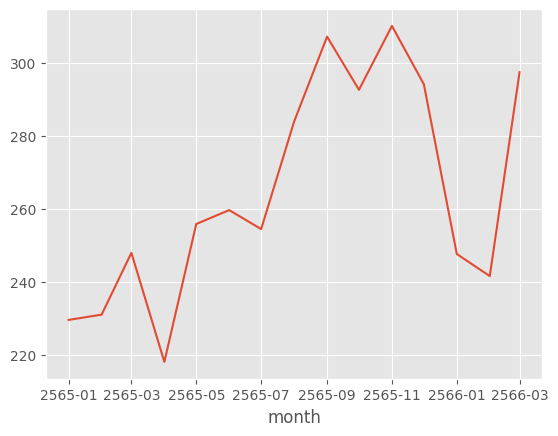

In [53]:
# # TODO: plot sample graph
sme_export_by_cat[sme_export_by_cat.index.get_level_values(1) == 'เครื่องจักรไฟฟ้า เครื่องอุปกรณ์ไฟฟ้า และส่วนประกอบของเครื่องดังกล่าว เครื่องบันทึกและเครื่องถถอดภาพและเสียงทางโทรทัศน์ รวมทั้งส่วนประกอบและอุปกรณ์ของเครื่องดังกล่าว'].sort_index().reset_index(level=1)['value_thb'].plot()

In [52]:
# sme_export_by_cat.tail(20)

Index([2556-06-01, 2556-11-01, 2556-11-01, 2556-11-01, 2556-11-01, 2556-12-01,
       2556-05-01, 2556-12-01, 2556-12-01, 2556-05-01,
       ...
       2566-01-01, 2566-01-01, 2566-02-01, 2566-03-01, 2566-03-01, 2566-01-01,
       2566-03-01, 2566-03-01, 2566-01-01, 2566-02-01],
      dtype='object', name='month', length=7385949)